# Prediction Model Building 

Now that we have a full pipeline to clean, prepare and balance our data for training we can start working on the prediction model.

The following imports are done because all previous functions were copied to python script files for easier navigation between notebooks, in this second step we will focus on using the data we cleaned to model predictions of the 'risk_score' parameter.

In [1]:
#imports
from src.pipeline import pipeline
from src.preprocess import BeforePipeline
from src.map import data_mapping
from src.config import cols_to_keep, ohe_cols
from src.imbalance import balance_dataframe
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, f1_score, classification_report
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import eli5
from eli5.sklearn import PermutationImportance


74


In [2]:
data_path = '../data/raw/data_chunck.parquet'

## Introduction to model building
Let's get started with model building, as we are dealing with very high dimensionality data, a lot of non linearity and mixed-type features, the optimal choice for us will probably be a tree based model, We will use a Random Forest Regressor, which is an application of bagging to decision trees with the additional “random subspace” trick: we create a large number of trees and each tree is trained on a bootstrap sample of the data chosen randomly with replacement, and at each split only a portion of the features are randomly chosen without replacement, generally $\sqrt{n}$ features for classification or $n/3$ for regression for $n$ features. 

This will save a ton of computing power while reducing the variance of our model.

In fact, if each tree result is a random variable, let's say we have $n$ random variables ${X_i}$ equally distributed but not necessarly independant, our model output $\tilde{X}$ would then be the average of all the results of the different trees:
$\tilde{X} = \frac{1}{n}\sum_{i=1}^{n} {X_i}$ if we let $Var({X_i}) = \sigma^{2}$ for all $i$ and $Cov({X_i},{X_j}) = \rho \sigma^{2}$ for all $i \neq j$ ($\rho$ being the coeificient of correlation),

Then, by a simple variance calculation we have that, $$Var(\tilde{X}) = \rho \sigma^{2} + \frac{1 - \rho}{n}\sigma^{2}$$
As n grow larger, $\frac{1 - \rho}{n}\sigma^{2} \xrightarrow[n \to \infty]{} 0$, we are then left with $Var(\tilde{X}) = \rho \sigma^{2} \leq  \sigma^{2}$ as $\rho \leq 1$.

So, the more trees we have, the more we reduce our model's output variance, this variance reduction is crucial for improving model stability, especially when evaluating the model across different economic scenarios to assess its robustness.

## Additional Note:
- In classification, the Random Forest aggregates by majority voting (which is equivalent to averaging the 0/1 votes and then thresholding) or by averaging the class probabilities. The variance formula applies to the probability estimates, which can then be thresholded to get the class label. This variance reduction in the probability estimates leads to more stable predictions.

In [4]:
#data collection
df = pd.read_parquet(data_path).sample(frac=1, random_state=0)
bp = BeforePipeline()

df = bp.all_before_pipeline(df)
df = df[cols_to_keep]

df_y = df['loan_status']
df = df.drop(columns='loan_status')


X_train, X_val, y_train, y_val = train_test_split(df, df_y, test_size=0.2)
rf = RandomForestClassifier(random_state=1,n_jobs=-1)
pipe = pipeline(model=rf, ver=False)
print(len(X_train))

mask = (X_train['annual_inc'] < 500_000) & (X_train['annual_inc'] > 0) #to remove outliers
X_train = X_train[mask]
y_train = y_train[mask]
print(len(X_train))

full_training_data = pd.concat([X_train, y_train], axis=1)
full_training_data.to_parquet('../data/clean/data_train_100%.parquet')

full_val_data = pd.concat([X_val, y_val], axis=1)
full_val_data.to_parquet('../data/clean/data_test_100%.parquet')

===> data_mapping called
===> num_data_prep called
===> clean infinites called
1334823
1332161


We can now directly test on the baseline random forest model

In [3]:
df = pd.read_parquet(data_path).sample(frac=1, random_state=0)
bp = BeforePipeline()

df = bp.all_before_pipeline(df)
df = df[cols_to_keep]

df_y = df['loan_status']
df = df.drop(columns='loan_status')


X_train, X_val, y_train, y_val = train_test_split(df, df_y, test_size=0.2)

X_train_sample = X_train.sample(frac=0.5, random_state=0)
y_train_sample = np.array(y_train.sample(frac=0.5, random_state=0)).ravel()
X_val_sample = X_val.sample(frac=0.5, random_state=0)
y_val_sample = np.array(y_val.sample(frac=0.5, random_state=0)).ravel()

xgb = XGBClassifier(n_estimators=200, random_state=0, n_jobs=-1, scale_pos_weight=6.7)
pipe = pipeline(model=xgb, ver=False)

scores = cross_val_score(estimator=pipe, X=X_train_sample, y=y_train_sample, cv=3, scoring='f1')
print(f'F1 cross validation scores: {scores}\nmean: {scores.mean()}')
print('-'*50)
scores = cross_val_score(estimator=pipe, X=X_train_sample, y=y_train_sample, cv=3, scoring='roc_auc')
print(f'ROC-AUC cross validation scores: {scores}\nmean: {scores.mean()}')
print('-'*50)
pipe.fit(X_train_sample, y_train_sample)
preds = pipe.predict(X_val_sample)
report = classification_report(y_true=y_val_sample, y_pred=preds)
print(report)

===> data_mapping called
===> num_data_prep called
===> clean infinites called
F1 cross validation scores: [0.3530624  0.35456945 0.35227469]
mean: 0.3533021792855168
--------------------------------------------------
ROC-AUC cross validation scores: [0.73150056 0.7339819  0.7301248 ]
mean: 0.7318690853905986
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.93      0.66      0.78    144385
         1.0       0.24      0.68      0.36     22468

    accuracy                           0.67    166853
   macro avg       0.59      0.67      0.57    166853
weighted avg       0.84      0.67      0.72    166853



Strong scores from the get go, I think it is safe to assume the feature selection part we did earlier really helped the model identify the relations between the features, let's check feature importance by permutation to see what parameter contributes to most to the model's decisions.

In [4]:
X_val_sample_trans = pipe['features'].transform(X_val_sample)
perms = (PermutationImportance(estimator=pipe['model'], scoring='accuracy', random_state=0)
         .fit(X_val_sample_trans, y_val_sample))

In [5]:
ohe_cols = pipe['features']['OHE'].get_feature_names_out().tolist()
num_cols = [col for col in X_val.columns if X_val[col].dtype != 'object']

feature_names = num_cols + ['purpose','addr_state'] + ['emp_length'] + ['earliest_cr_line'] + ohe_cols

eli5.show_weights(perms, feature_names=feature_names)

Weight,Feature
0.0169 ± 0.0006,revol_bal
0.0152 ± 0.0008,percent_bc_gt_75
0.0124 ± 0.0009,bc_open_to_buy
0.0108 ± 0.0005,grade_D
0.0096 ± 0.0012,installment
0.0057 ± 0.0011,revol_util
0.0051 ± 0.0014,int_rate
0.0051 ± 0.0004,mo_sin_rcnt_tl
0.0050 ± 0.0012,dti
0.0029 ± 0.0005,num_actv_rev_tl


I think the results are very interesting, no feature is contributing by itself way more than all others, and with the very solid AUC and F1 scores we have that means the model was able to extract complex non-linear relations from the data, it may be interesting to look at how a simpler model with just two key features (annual income and dept to income ratio) would perform and compare.

In [40]:
X=X_train_sample[['dti', 'annual_inc']]

scores = cross_val_score(estimator=rf, X=X, y=y_train_sample, cv=3, scoring='f1')
print(f'F1 cross validation scores: {scores}\nmean: {scores.mean()}')
print('-'*50)
scores = cross_val_score(estimator=rf, X=X, y=y_train_sample, cv=3, scoring='roc_auc')
print(f'ROC-AUC cross validation scores: {scores}\nmean: {scores.mean()}')

F1 cross validation scores: [0.73586618 0.73146527 0.73292087]
mean: 0.7334174402894672
--------------------------------------------------
ROC-AUC cross validation scores: [0.82911413 0.82570536 0.82616442]
mean: 0.8269946355123442


### First Results

| metric/model | Simple Model | Full Model |
| ------------ | ------------ | ---------- |
| F1 Score     | 0.73         | 0.90       |
| ROC-AUC      | 0.83         | 0.95       |

The simple model is surprizingly good (that indicates that debt to income and annual income are strong predictive features).

- The jump in performance is huge $83\% \xrightarrow[+12\%]{} 95\%$ in AUC shows way better ranking ability for the new model that's way worth the added complexity as we still have only ~50 Columns.

- The jump in F1 Score to $90\%$ tells us the precision and recall of the full model are way more balanced (we're checking confusion matrix just after)

- Like we hypothesised earlier on the full model, even through individual features may not have a lot of importance at first glance, the features as a whole are working very good together, it indicates robust, multi-faceted decision making rather than over-reliance on any single variable. 

Before looking at shape values for more insights, we check the confusion matrix on validation.

C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

F1 cross validation scores: [0.90110809 0.89658804 0.89712151 0.88964202 0.62232874]
mean: 0.841357680022781


C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


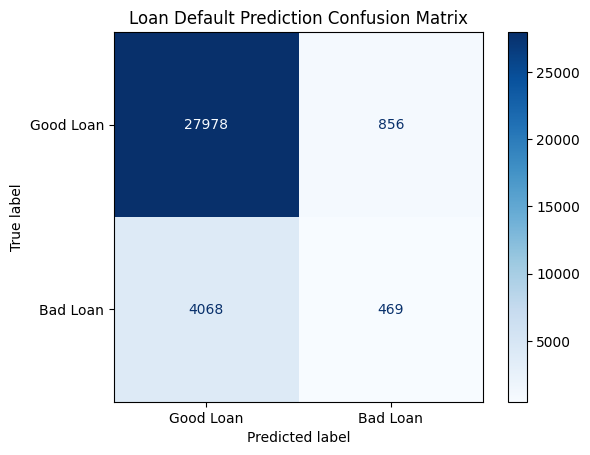

In [61]:
pipe['model'].fit(X_train_sample, y_train_sample)

X_train_sample = X_train.sample(frac=0.1, random_state=0)
y_train_sample = y_train.sample(frac=0.1, random_state=0)
X_val_sample = X_val.sample(frac=0.1, random_state=0)
y_val_sample = y_val.sample(frac=0.1, random_state=0)

X_val_sample_trans = pipe['features'].transform(X_val_sample)
X_val_sample = pd.DataFrame(X_val_sample_trans, columns=feature_names)

full_X = pd.concat([X_train_sample, X_val_sample], axis=0)
full_y = pd.concat([y_train_sample, y_val_sample], axis=0)

scores = cross_val_score(estimator=pipe['model'], X=full_X, y=full_y, scoring='f1')
print(f'F1 cross validation scores: {scores}\nmean: {scores.mean()}')


preds = pipe['model'].predict(X_val_sample_trans)
mat = confusion_matrix(y_true=y_val_sample, y_pred=preds)

disp = ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=["Good Loan", "Bad Loan"])
disp.plot(cmap="Blues", values_format="d")  # "d" for integers
plt.title("Loan Default Prediction Confusion Matrix")
plt.show()

In [76]:
from xgboost import XGBClassifier

df = pd.read_parquet(data_path).sample(frac=0.1)
bp = BeforePipeline()

df = bp.all_before_pipeline(df)
df = df[cols_to_keep]
df_y = df['loan_status']
df = df.drop(columns='loan_status')

xgb = XGBClassifier()
pipe = pipeline(model=xgb, ver=False)

scores =  cross_val_score(estimator=pipe, X=df, y=df_y, scoring='roc_auc')
print(f'Baseline XGBoost Results (Without SMOTETomek):')
print(f'cross validation ROC AUC scores: {scores}\nmean: {scores.mean()}')

===> data_mapping called
===> num_data_prep called
===> clean infinites called
Baseline XGBoost Results (Without SMOTETomek):
cross validation ROC AUC scores: [0.71693265 0.72347761 0.7132944  0.71842239 0.71456153]
mean: 0.7173377145583195
